## Current poliastro version

In [1]:
import numpy as np
from astropy import units as u

from poliastro.bodies import Earth
from poliastro.twobody import State, propagation

In [2]:
k = Earth.k
r0 = [1131.340, -2282.343, 6672.423] * u.km
v0 = [-5.64305, 4.30333, 2.42879] * u.km / u.s
tof = 40 * u.min

In [3]:
r0

<Quantity [ 1131.34 ,-2282.343, 6672.423] km>

In [4]:
v0

<Quantity [-5.64305, 4.30333, 2.42879] km / s>

In [5]:
k

<Quantity 398600.0 km3 / s2>

In [6]:
tof

<Quantity 40.0 min>

In [7]:
propagation.kepler?

In [8]:
r, v = propagation.kepler(k.to(u.km**3 / u.s**2).value,
                          r0.to(u.km).value,
                          v0.to(u.km / u.s).value,
                          tof.to(u.s).value)
r *= u.km
v *= u.km / u.s

In [9]:
r

<Quantity [-4219.77617109, 4363.04569716,-3958.74972246] km>

In [10]:
v

<Quantity [ 3.68983773,-1.91670933,-6.11251847] km / s>

Prepare the inputs to measure performance:

In [9]:
k_ = k.to(u.km**3 / u.s**2).value
r0_ = r0.to(u.km).value
v0_ = v0.to(u.km / u.s).value
tof_ = tof.to(u.s).value

In [12]:
%timeit propagation.kepler(k_, r0_, v0_, tof_)

The slowest run took 6.23 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 10.5 µs per loop


## Pure Python version

Now we write our own implementation in pure Python. We will use numbified $c_2$ and $c_3$ functions for the moment.

In [11]:
from poliastro.stumpff import c2, c3

def kepler_py(k, r0, v0, tof):
    # Prepare input
    r0 = np.asarray(r0).astype(np.float)
    v0 = np.asarray(v0).astype(np.float)
    tof = float(tof)
    assert r0.shape == (3,)
    assert v0.shape == (3,)

    # Cache some results
    dot_r0v0 = np.dot(r0, v0)
    norm_r0 = np.linalg.norm(r0)
    sqrt_mu = np.sqrt(k)
    alpha = -np.dot(v0, v0) / k + 2 / norm_r0

    # Newton-Raphson iteration on the Kepler equation
    # Conservative initial guess
    xi = sqrt_mu * tof / norm_r0
    numiter = 50
    count = 0
    while count < numiter:
        psi = xi**2 * alpha
        norm_r = xi**2 * c2(psi) + dot_r0v0 / sqrt_mu * xi * (1 - psi * c3(psi)) + norm_r0 * (1 - psi * c2(psi))
        xi_new = xi + (sqrt_mu * tof - xi**3 * c3(psi) - dot_r0v0 / sqrt_mu * xi**2 * c2(psi) -
                       norm_r0 * xi * (1 - psi * c3(psi))) / norm_r
        err = np.abs((xi_new - xi) / xi_new)
        if err < 1e-10:
            break
        else:
            xi = xi_new
            count += 1
    else:
        print("No convergence")
        return

    # Compute Lagrange coefficients
    f = 1 - xi**2 / norm_r0 * c2(psi)
    g = tof - xi**3 / sqrt_mu * c3(psi)

    gdot = 1 - xi**2 / norm_r * c2(psi)
    fdot = sqrt_mu / (norm_r * norm_r0) * xi * (psi * c3(psi) - 1)

    # Return position and velocity vectors
    r = f * r0 + g * v0
    v = fdot * r0 + gdot * v0

    assert np.abs(f * gdot - fdot * g - 1) < 1e-6

    return r, v

In [14]:
r_py, v_py = kepler_py(k_, r0_, v0_, tof_)
r_py *= u.km
v_py *= u.km / u.s

In [15]:
np.testing.assert_array_almost_equal(r_py.value, r.value)
np.testing.assert_array_almost_equal(v_py.value, v.value)

In [16]:
r_py

<Quantity [-4219.77617109, 4363.04569716,-3958.74972246] km>

In [17]:
%timeit kepler_py(k_, r0_, v0_, tof_)

The slowest run took 4.72 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 74.8 µs per loop


In [18]:
%timeit propagation.kepler(k_, r0_, v0_, tof_)

100000 loops, best of 3: 11.2 µs per loop


Our pure Python, non optimized version **is not *that* bad**! It stays in the same order of magnitude as the Fortran version for elliptic orbits at least. Let us see how can we improve the results.

In [19]:
%load_ext line_profiler

In [20]:
%lprun -f kepler_py kepler_py(k_, r0_, v0_, tof_)

According to line_profiler, 13 % of the time is spent in the two `asarray` calls and 14.5 % in the single `norm` computation.

In [21]:
%timeit np.linalg.norm(r0_)

The slowest run took 6.72 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 8.33 µs per loop


In [22]:
%timeit np.sqrt(np.dot(r0_, r0_))

The slowest run took 10.64 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 2.5 µs per loop


We can try and replace `linalg.norm` with the square root of the dot product. We can go further and assume the input are float arrays to save some more microseconds.

In [23]:
def kepler_py2(k, r0, v0, tof):
    # Algorithm parameters
    rtol = 1e-10
    numiter = 50
    
    # Cache some results
    dot_r0v0 = np.dot(r0, v0)
    norm_r0 = np.sqrt(np.dot(r0, r0))
    sqrt_mu = np.sqrt(k)
    alpha = -np.dot(v0, v0) / k + 2 / norm_r0

    # Newton-Raphson iteration on the Kepler equation
    # Conservative initial guess
    xi = sqrt_mu * tof / norm_r0
    count = 0
    while count < numiter:
        psi = xi * xi * alpha
        c2_psi = c2(psi)
        c3_psi = c3(psi)
        norm_r = xi * xi * c2_psi + dot_r0v0 / sqrt_mu * xi * (1 - psi * c3_psi) + norm_r0 * (1 - psi * c2_psi)
        xi_new = xi + (sqrt_mu * tof - xi * xi * xi * c3_psi - dot_r0v0 / sqrt_mu * xi * xi * c2_psi -
                       norm_r0 * xi * (1 - psi * c3_psi)) / norm_r
        if abs((xi_new - xi) / xi_new) < rtol:
            break
        else:
            xi = xi_new
            count += 1
    else:
        raise RuntimeError("Convergence could not be achieved under "
                           "%d iterations" % numiter)

    # Compute Lagrange coefficients
    f = 1 - xi**2 / norm_r0 * c2_psi
    g = tof - xi**3 / sqrt_mu * c3_psi

    gdot = 1 - xi**2 / norm_r * c2_psi
    fdot = sqrt_mu / (norm_r * norm_r0) * xi * (psi * c3_psi - 1)

    # Return position and velocity vectors
    r = f * r0 + g * v0
    v = fdot * r0 + gdot * v0

    assert np.abs(f * gdot - fdot * g - 1) < rtol

    return r, v

In [24]:
r_py2, v_py2 = kepler_py2(k_, r0_, v0_, tof_)
r_py2 *= u.km
v_py2 *= u.km / u.s

In [25]:
np.testing.assert_array_almost_equal(r_py2.value, r.value)
np.testing.assert_array_almost_equal(v_py2.value, v.value)

In [26]:
%timeit kepler_py2(k_, r0_, v0_, tof_)

The slowest run took 7.97 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 38.1 µs per loop


## Optimized Python + numba version

We cut the time in half! We still have another bullet: numba. This will require some work though, because we will have to provide some work arrays from outside to use the functions `np.abs` and `np.dot`, and in particular the latest one is not available.

In [12]:
import numba

def kepler_numba(k, r0, v0, tof, numiter=50, rtol=1e-10):
    """Propagates Keplerian orbit.

    Parameters
    ----------
    k : float
        Gravitational constant of main attractor (km^3 / s^2).
    r0 : array
        Initial position (km).
    v0 : array
        Initial velocity (km).
    tof : float
        Time of flight (s).
    numiter : int, optional
        Maximum number of iterations, default to 50.
    rtol : float, optional
        Maximum relative error permitted, default to 1e-10.

    Raises
    ------
    RuntimeError
        If the algorithm didn't converge.

    Notes
    -----
    This algorithm is based on Vallado implementation, and does basic Newton
    iteration on the Kepler equation written using universal variables. Battin
    claims his algorithm uses the same amount of memory but is between 40 %
    and 85 % faster.

    """
    # Compute Lagrange coefficients
    try:
        f, g, fdot, gdot = _kepler(k, r0, v0, tof, numiter, rtol)
    except RuntimeError:
        raise RuntimeError("Convergence could not be achieved under "
                           "%d iterations" % numiter)

    assert np.abs(f * gdot - fdot * g - 1) < rtol

    # Return position and velocity vectors
    r = f * r0 + g * v0
    v = fdot * r0 + gdot * v0

    return r, v

@numba.njit('f8(f8[:], f8[:])')
def dot(u, v):
    dp = 0.0
    for ii in range(u.shape[0]):
        dp += u[ii] * v[ii]
    return dp

@numba.njit
def _kepler(k, r0, v0, tof, numiter, rtol):
    # Cache some results
    dot_r0v0 = dot(r0, v0)
    norm_r0 = dot(r0, r0) ** .5
    sqrt_mu = k**.5
    alpha = -dot(v0, v0) / k + 2 / norm_r0

    # Newton-Raphson iteration on the Kepler equation
    # Conservative initial guess
    xi = sqrt_mu * tof / norm_r0
    xi_new = xi
    count = 0
    while count < numiter:
        psi = xi * xi * alpha
        c2_psi = c2(psi)
        c3_psi = c3(psi)
        norm_r = xi * xi * c2_psi + dot_r0v0 / sqrt_mu * xi * (1 - psi * c3_psi) + norm_r0 * (1 - psi * c2_psi)
        xi_new = xi + (sqrt_mu * tof - xi * xi * xi * c3_psi - dot_r0v0 / sqrt_mu * xi * xi * c2_psi -
                       norm_r0 * xi * (1 - psi * c3_psi)) / norm_r
        if abs((xi_new - xi) / xi_new) < rtol:
            break
        else:
            xi = xi_new
            count += 1
    else:
        raise RuntimeError

    # Compute Lagrange coefficients
    f = 1 - xi**2 / norm_r0 * c2_psi
    g = tof - xi**3 / sqrt_mu * c3_psi

    gdot = 1 - xi**2 / norm_r * c2_psi
    fdot = sqrt_mu / (norm_r * norm_r0) * xi * (psi * c3_psi - 1)

    return f, g, fdot, gdot

In [28]:
r_numba, v_numba = kepler_numba(k_, r0_, v0_, tof_)
r_numba *= u.km
v_numba *= u.km / u.s

In [29]:
np.testing.assert_array_almost_equal(r_numba.value, r.value)
np.testing.assert_array_almost_equal(v_numba.value, v.value)

In [30]:
r_numba

<Quantity [-4219.77617109, 4363.04569716,-3958.74972246] km>

In [31]:
v_numba

<Quantity [ 3.68983773,-1.91670933,-6.11251847] km / s>

In [32]:
%timeit kepler_numba(k_, r0_, v0_, tof_)

The slowest run took 6.97 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 12.3 µs per loop


**We achieved a 0.9x factor with the pure Python version**. We still have to test what happens for longer times and for non-elliptic orbits and compare both cases, but in any case the results are promising.

## Benchmark

We will cover a range of values of eccentricity to compare both versions, plotting computation time vs time of flight

In [33]:
%matplotlib inline
from poliastro.twobody import State
from poliastro.plotting import plot
import matplotlib.pyplot as plt

[  2400.           4835.86478811   7271.72957622   9707.59436432
  12143.45915243  14579.32394054  17015.18872865  19451.05351675
  21886.91830486  24322.78309297]


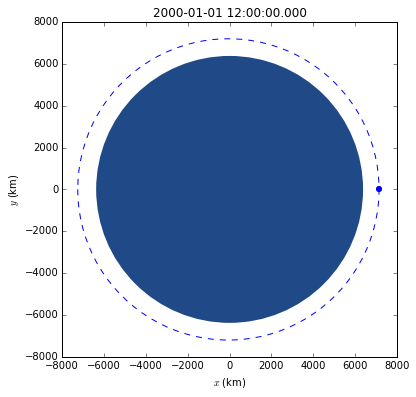

In [34]:
ss = State.from_vectors(Earth, r0, v0)
tof_range = np.linspace(tof.to(u.s).value,
                        (ss.period * 4).to(u.s).value,
                        num=10)
print(tof_range)
plot(ss)

In [35]:
res_fortran = []
res_numba = []
for tof_ in tof_range:
    timeit_res_fortran = %timeit -o propagation.kepler(k_, r0_, v0_, tof_)
    timeit_res_numba = %timeit -o kepler_numba(k_, r0_, v0_, tof_)
    res_fortran.append(timeit_res_fortran.best)
    res_numba.append(timeit_res_numba.best)

The slowest run took 4.03 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 11 µs per loop
100000 loops, best of 3: 12.4 µs per loop
100000 loops, best of 3: 11.3 µs per loop
The slowest run took 4.14 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 12.2 µs per loop
100000 loops, best of 3: 11.2 µs per loop
100000 loops, best of 3: 12.1 µs per loop
100000 loops, best of 3: 11.1 µs per loop
The slowest run took 4.28 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 12.2 µs per loop
100000 loops, best of 3: 11.3 µs per loop
The slowest run took 4.17 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 12.2 µs per loop
100000 loops, best of 3: 11.2 µs per loop
The slowest run took 4.05 times longer than the fastest. This could 

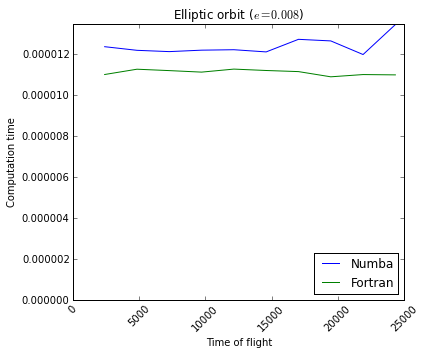

In [36]:
plt.figure(figsize=(6, 5))
plt.plot(tof_range, res_numba, label="Numba")
plt.plot(tof_range, res_fortran, label="Fortran")
plt.legend(loc=4)
plt.ylim(0)
plt.xlabel("Time of flight")
plt.xticks(rotation=45)
plt.ylabel("Computation time")
plt.title("Elliptic orbit ($e = {:.3f}$)".format(ss.ecc))
plt.tight_layout()

[  2400.           6007.38086754   9614.76173509  13222.14260263
  16829.52347018  20436.90433772  24044.28520526  27651.66607281
  31259.04694035  34866.42780789]


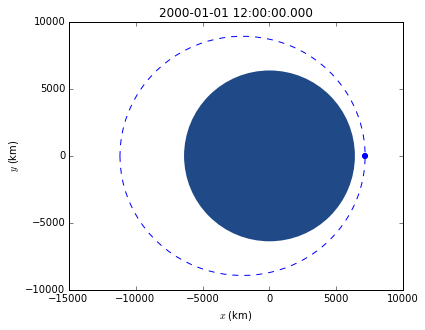

In [37]:
ss = State.from_vectors(Earth, r0, v0 * 1.1)
tof_range = np.linspace(tof.to(u.s).value,
                        (ss.period * 4).to(u.s).value,
                        num=10)
print(tof_range)
plot(ss)

In [38]:
res_fortran = []
res_numba = []
r0_ = ss.r.to(u.km).value
v0_ = ss.v.to(u.km / u.s).value
for tof_ in tof_range:
    timeit_res_fortran = %timeit -o propagation.kepler(k_, r0_, v0_, tof_)
    timeit_res_numba = %timeit -o kepler_numba(k_, r0_, v0_, tof_)
    res_fortran.append(timeit_res_fortran.best)
    res_numba.append(timeit_res_numba.best)

The slowest run took 4.19 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 11.3 µs per loop
100000 loops, best of 3: 12.5 µs per loop
100000 loops, best of 3: 11 µs per loop
100000 loops, best of 3: 12.9 µs per loop
100000 loops, best of 3: 10.9 µs per loop
The slowest run took 4.01 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 12.7 µs per loop
The slowest run took 4.29 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 11.1 µs per loop
The slowest run took 4.15 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 12.6 µs per loop
100000 loops, best of 3: 10.7 µs per loop
100000 loops, best of 3: 12.6 µs per loop
The slowest run took 4.31 times longer than the fastest. This could mean that an intermediate result is being 

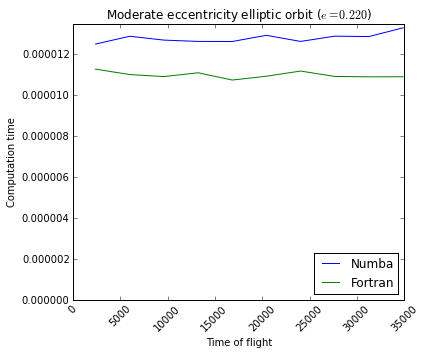

In [39]:
plt.figure(figsize=(6, 5))
plt.plot(tof_range, res_numba, label="Numba")
plt.plot(tof_range, res_fortran, label="Fortran")
plt.legend(loc=4)
plt.ylim(0)
plt.xlabel("Time of flight")
plt.xticks(rotation=45)
plt.ylabel("Computation time")
plt.title("Moderate eccentricity elliptic orbit ($e = {:.3f}$)".format(ss.ecc))
plt.tight_layout()

[   2400.           60937.43670331  119474.87340662  178012.31010993
  236549.74681324  295087.18351655  353624.62021986  412162.05692317
  470699.49362648  529236.93032979]


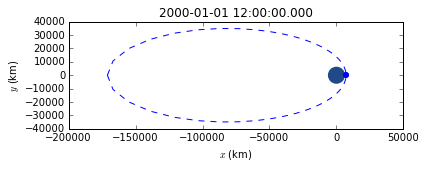

In [40]:
ss = State.from_vectors(Earth, r0, v0 * 1.38)
tof_range = np.linspace(tof.to(u.s).value,
                        (ss.period * 2).to(u.s).value,
                        num=10)
print(tof_range)
plot(ss)

In [41]:
res_fortran = []
res_numba = []
r0_ = ss.r.to(u.km).value
v0_ = ss.v.to(u.km / u.s).value
for tof_ in tof_range:
    timeit_res_fortran = %timeit -o propagation.kepler(k_, r0_, v0_, tof_)
    timeit_res_numba = %timeit -o kepler_numba(k_, r0_, v0_, tof_)
    res_fortran.append(timeit_res_fortran.best)
    res_numba.append(timeit_res_numba.best)

The slowest run took 4.31 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 11.1 µs per loop


AssertionError: 

<div class="alert alert-danger">**Here I am starting to have problems with the propagation**.

In principle convergence is achieved, but Vallado checks the assertion against 1e-5 always. This probably means using the same tolerance for the convergence and the assertion is too much, but do I have a way to prove it?</div>

In [42]:
%pdb
kepler_numba(k_, r0_, v0_, tof_, rtol=1e-12)

Automatic pdb calling has been turned ON


(array([-12884.90767054,  10484.55996297,   2223.90242549]),
 array([-3.76627342,  3.92262705, -3.67693817]))

In [43]:
kepler_numba(k_, r0_, v0_, tof_, rtol=1e-20)

AssertionError: 

> <ipython-input-27-47b601c8b9d3>(41)kepler_numba()
     40 
---> 41     assert np.abs(f * gdot - fdot * g - 1) < rtol
     42 

ipdb> p np.abs(f * gdot - fdot * g - 1)
6.6613381477509392e-16
ipdb> p rtol
1e-20
ipdb> p f * gdot - fdot * g
1.0000000000000007
ipdb> p f * gdot
-0.17451735819387165
ipdb> p fdot * g
-1.1745173581938724
ipdb> p np.linalg.cond([[f,g],[fdot,gdot]])
2519127.1584023945
ipdb> p "%.e" % np.linalg.cond([[f,g],[fdot,gdot]])
'3e+06'
ipdb> c


<div class="alert alert-warning">**The transition matrix appears to be ill-conditioned**. Is this a general result for parabolic or near-parabolic orbits?</div>

Let us try last a hyperbolic orbit:

[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]


/home/juanlu/Development/Python/poliastro/poliastro/twobody/state.py:256: RuntimeWarning: invalid value encountered in sqrt
  n = np.sqrt(self.attractor.k / self.a ** 3) * u.rad


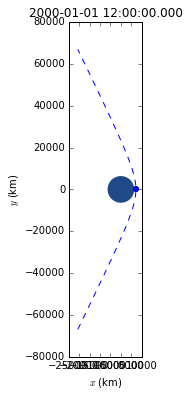

In [44]:
ss = State.from_vectors(Earth, r0, v0 * 1.8)
tof_range = np.linspace(tof.to(u.s).value,
                        (ss.period * 2).to(u.s).value,
                        num=10)
print(tof_range)
plot(ss)

<div class="alert alert-danger">**There is a bug in poliastro**. We will have to fix it :)</div>

In [13]:
res_fortran = []
res_numba = []
r0_ = r0.value
v0_ = 1.8 * v0.value
tof_range = np.linspace(tof.to(u.s).value,
                        100 * tof.to(u.s).value,
                        num=10)
for tof_ in tof_range:
    timeit_res_fortran = %timeit -o propagation.kepler(k_, r0_, v0_, tof_)
    timeit_res_numba = %timeit -o kepler_numba(k_, r0_, v0_, tof_)
    res_fortran.append(timeit_res_fortran.best)
    res_numba.append(timeit_res_numba.best)

100000 loops, best of 3: 11.9 µs per loop
The slowest run took 14702.26 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 12.8 µs per loop
100000 loops, best of 3: 11.1 µs per loop
100000 loops, best of 3: 17 µs per loop
100000 loops, best of 3: 11 µs per loop


RuntimeError: Convergence could not be achieved under 50 iterations

<div class="alert alert-danger">**The initial guess for hyperbolic orbits is very bad**. This leads to very high number of iterations. The algorithm needs polishing in these cases.</div>

In [34]:
kepler_numba(k_, r0_, v0_, tof_, 80)

(array([-361927.91045702,  316320.36232601,  -47558.03604272]),
 array([-6.33593488,  5.57736688, -1.03348124]))

In [31]:
%timeit kepler_numba(k_, r0_, v0_, tof_, 80)

10000 loops, best of 3: 67.4 µs per loop


In [33]:
propagation.kepler(k_, r0_, v0_, tof_)

(array([-361927.91045703,  316320.36232602,  -47558.03604272]),
 array([-6.33593488,  5.57736688, -1.03348124]))

In [32]:
%timeit propagation.kepler(k_, r0_, v0_, tof_)

The slowest run took 4.87 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 27.9 µs per loop


<div class="alert alert-info">Pending:

<ul>
<li>Complete with graphs of time vs universal anomaly to study convergence properties.</li>
<li>Use appropriate initial guess for hyperbolic orbits.</li>
</ul>
</div>

---

Another interesting side-thought: can I use the `scipy.optimize` functions with numbified callbacks? Does it save performance in this case?